In [1]:
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
import pickle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import math
import numpy  as np

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

In [22]:
labelList = ["Benign", "DoS", "PortScan", "DDoS", "SSH-Patator", "FTP-Patator", "Web Attack", "Bot"]

#加载模型、分布字典和测试集
def load_obj(name):
    with open('../DistributionDictionary/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

learning_rate = 0.001
model = keras.models.load_model('../DistributionDictionary/Test7_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

test_X = np.load("../DistributionDictionary/test7_test_dataset_X.npy")
test_y = np.load("../DistributionDictionary/test7_test_dataset_y.npy")

distributions = {}
distributions['Benign'] = load_obj("Benign_Distribution_set")
distributions['DoS'] = load_obj("DoS_Distribution_set")
distributions['PortScan'] = load_obj("PortScan_Distribution_set")
distributions['DDoS'] = load_obj("DDoS_Distribution_set")
distributions['SSH-Patator'] = load_obj("SSH_Distribution_set")
distributions['FTP-Patator'] = load_obj("FTP_Distribution_set")
distributions['Web Attack'] = load_obj("Web_Distribution_set")
distributions['Bot'] = load_obj("Bot_Distribution_set")
feature_numbers = 10
attack_types = 7  #总已知攻击种类


def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset[' Label'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

#定义difference weight,取值0~1
def calculate_dw(distribution_1, distribution_2, feature_index):
    count1 = calculate_count(distribution_1, feature_index)
    count2 = calculate_count(distribution_2, feature_index)
    h = 20
    dw = 0
    for i in range(h):
        start = i*5
        end = start + 5
        T1 = distribution_1[str(feature_index)][str(start) + '-' + str(end)]/count1
        T2 = distribution_2[str(feature_index)][str(start) + '-' + str(end)]/count2
        dw += abs(T1 - T2)
    return dw/2
#用于计算分布字典里的实例数
def calculate_count(distribution, feature_index):
    h = 20
    count = 0
    for i in range(h):
        start = i*5
        end = start + 5
        count += distribution[str(feature_index)][str(start) + '-' + str(end)]
    return count
#定义hdw，hybird difference weight  第二个参数为：hdw应用的对应得分公式的对应的哪种字典
def calculate_hdw(feature_index, label):
    base = 0
    for key in distributions:
        if(key == label):
            continue
        dw = calculate_dw(distributions[label], distributions[key], feature_index)
        if(dw > base):
            base = dw
    return base

#计算例子在某种标签上的得分，需要提供对应标签, 这个标签的的分布统计字典
def get_score(example, distributeObj, label):    
    score = 0
    count = calculate_count(distributeObj, 0)  #取哪个特征都一样
    minBase = 1
    baseArr = []
    for i in range(feature_numbers):

        start = int(example[i]/0.05//1)*5   #取200个分组里的分组起始位置
        if(start == 100):     #特殊处理当该属性为1.0时溢出的情况
            start = 95      
        end = start + 5
        dataRange = '{0}-{1}'.format(start, end )
        base = distributeObj[str(i)][dataRange]/count
        if(base != 0 and base < minBase):
            minBase = base
        baseArr.append(base)
        
    for i in range(feature_numbers):
        if(baseArr[i] != 0):
            score += math.log(baseArr[i]) * calculate_hdw(i, label)  / feature_numbers
        else:
            score += math.log(minBase) * calculate_hdw(i, label)  / feature_numbers
            
    return score


def get_score_threshold(dataset_x, dataset_y):
    #5个分数数组，表示在这个label字典下label实例的得分情况
    Scores = {
        "Benign" : [],
        "DoS" : [],
        "PortScan" : [],
        "DDoS" : [],
        "SSH-Patator" : [],        
        "FTP-Patator" : [],
        "Web Attack" : [],
        "Bot" : []
    }
    for i,item in enumerate(dataset_x):
        if(dataset_y.values[i].astype('int') == 0):
            
            Scores["Benign"].append(get_score(item, distributions['Benign'], 'Benign'))
            
        elif(dataset_y.values[i].astype('int') == 1):
            
            Scores["DoS"].append(get_score(item, distributions['DoS'], 'DoS'))
            
        elif(dataset_y.values[i].astype('int') == 2):
            
            Scores["PortScan"].append(get_score(item, distributions['PortScan'], 'PortScan'))
            
        elif(dataset_y.values[i].astype('int') == 3):
            
            Scores["DDoS"].append(get_score(item, distributions['DDoS'], 'DDoS'))
            
        elif(dataset_y.values[i].astype('int') == 4):
            
            Scores["SSH-Patator"].append(get_score(item, distributions['SSH-Patator'], 'SSH-Patator'))
        
        elif(dataset_y.values[i].astype('int') == 5):
            
            Scores["FTP-Patator"].append(get_score(item, distributions['FTP-Patator'], 'FTP-Patator'))
            
        elif(dataset_y.values[i].astype('int') == 6):
            
            Scores["Web Attack"].append(get_score(item, distributions['Web Attack'], 'Web Attack'))
            
        elif(dataset_y.values[i].astype('int') == 7):
            
            Scores["Bot"].append(get_score(item, distributions['Bot'], 'Bot'))
            
    thresholds = []
    
    for item in Scores.values():
        item.sort()
        thresholds.append(item[len(item)//10])    #取”将样例分成1：9“的threshold
    return thresholds

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + np.exp(-x))

def get_Full_Scores(dataset_x, dataset_y): 
    Full_Scores = {
        "Benign" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "DoS" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "PortScan" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "DDoS" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "SSH-Patator" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },        
        "FTP-Patator" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "Web Attack" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        },
        "Bot" : {
            "Benign" : [],
            "DoS" : [],
            "PortScan" : [],
            "DDoS" : [],
            "SSH-Patator" : [],        
            "FTP-Patator" : [],
            "Web Attack" : [],
            "Bot" : []
        }
    }
    for i,item in enumerate(dataset_x):
        itemLabel = labelList[int(dataset_y.values[i])]
        Full_Scores["Benign"][itemLabel].append(get_score(item, distributions["Benign"], "Benign")) 
        Full_Scores["DoS"][itemLabel].append(get_score(item, distributions["DoS"], "DoS"))
        Full_Scores["PortScan"][itemLabel].append(get_score(item, distributions["PortScan"], "PortScan"))
        Full_Scores["DDoS"][itemLabel].append(get_score(item, distributions["DDoS"], "DDoS"))
        Full_Scores["SSH-Patator"][itemLabel].append(get_score(item, distributions["SSH-Patator"], "SSH-Patator"))
        Full_Scores["FTP-Patator"][itemLabel].append(get_score(item, distributions["FTP-Patator"], "FTP-Patator"))
        Full_Scores["Web Attack"][itemLabel].append(get_score(item, distributions["Web Attack"], "Web Attack"))
        Full_Scores["Bot"][itemLabel].append(get_score(item, distributions["Bot"], "Bot"))
    return Full_Scores
    




In [3]:
def read_csv(dataroot):
    df=pd.read_csv(dataroot,header=0,low_memory=False)   
    pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
    df['Flow Bytes/s']=df['Flow Bytes/s'].astype('float64')
    df[' Flow Packets/s']=df[' Flow Packets/s'].astype('float64')
    df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(),inplace=True)
    df[' Flow Packets/s'].fillna(df[' Flow Packets/s'].mean(),inplace=True)
    return df

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset[' Label'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 

def labels_separate(dataset):
    y_ = dataset[' Label']
    temp = dataset
    temp.drop([' Label'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    if label == 'BENIGN':
        return 0
    if label == 'DoS':
        return 1
    if label == 'PortScan':
        return 2
    if label == 'DDoS':
        return 3
    if label == 'SSH-Patator':
        return 4
    if label == 'FTP-Patator':
        return 5
    if label == 'Web Attack':
        return 6
    if label == 'Bot':
        return 7
    return -1   #-1表示出错

def filter_labels(dataset):
    dataset[' Label'] = dataset[' Label'].apply(labels_map)
    return dataset
#特征选取
def feature_selection(dataset):
    return dataset[[
        'Total Length of Fwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Mean', 
        ' Bwd Packet Length Mean', ' Packet Length Mean', ' Packet Length Std', ' Average Packet Size', 
        ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
        ' Label'
    ]]

In [4]:
#DDoS
df_1 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_1 = df_1.drop(df_1[df_1[' Label'] == 'BENIGN'].index)
df_1 = df_1.sample(n=5000,random_state=1, replace=False)
df_1_train, df_1_test = split_valid_from_train(df_1, 0.2)
#PortScan
df_2 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_2 = df_2.drop(df_2[df_2[' Label'] == 'BENIGN'].index)
df_2 = df_2.sample(n=5000,random_state=1, replace=False)
df_2_train, df_2_test = split_valid_from_train(df_2, 0.2)
#Bot
df_3 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_3 = df_3.drop(df_3[df_3[' Label'] == 'BENIGN'].index)
df_3 = df_3.sample(n=5000,random_state=1, replace=True)
df_3_train, df_3_test = split_valid_from_train(df_3, 0.2)
#Benign
df_4 = read_csv("../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
df_4 = df_4.sample(n=50000,random_state=1, replace=False)
df_4_train, df_4_test = split_valid_from_train(df_4, 0.2)
#Web attack
df_6 = read_csv("../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_6 = df_6.drop(df_6[df_6[' Label'] == 'BENIGN'].index)
df_6 = df_6.sample(n=5000,random_state=1, replace=True)
df_6[' Label'] = df_6[' Label'].apply(lambda x: 'Web Attack')
df_6_train, df_6_test = split_valid_from_train(df_6, 0.2)
#FTP-Patator and SSH-Patator
df_7 = read_csv("../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
df_7 = df_7.drop(df_7[df_7[' Label'] == 'BENIGN'].index)
df_7_1 = df_7.drop(df_7[df_7[' Label'] == 'FTP-Patator'].index)
df_7_2 = df_7.drop(df_7[df_7[' Label'] == 'SSH-Patator'].index)
df_7_1 = df_7_1.sample(n=5000,random_state=1, replace=False)
df_7_2 = df_7_2.sample(n=5000,random_state=1, replace=False)
df_7_1_train, df_7_1_test = split_valid_from_train(df_7_1, 0.2)
df_7_2_train, df_7_2_test = split_valid_from_train(df_7_2, 0.2)
#DoS
df_8 = read_csv("../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
df_8 = df_8.drop(df_8[df_8[' Label'] == 'BENIGN'].index)
df_8 = df_8.sample(n=5000,random_state=1, replace=False)
df_8[' Label'] = df_8[' Label'].apply(lambda x: 'DoS')
df_8_train, df_8_test = split_valid_from_train(df_8, 0.2)

#整合
df_train = df_1_train.append([df_2_train, df_3_train, df_4_train, df_6_train, df_7_1_train,df_7_2_train,df_8_train])
df_test = df_1_test.append([df_2_test, df_3_test, df_4_test, df_6_test, df_7_1_test,df_7_2_test,df_8_test])

In [5]:
#整合后再乱序一下
df_train = shuffle(df_train)
#标签的字符转化成数字
df_train = filter_labels(df_train)
#特征选择
df_train = feature_selection(df_train)
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
#Normalization
scaler = preprocessing.MinMaxScaler()
df_train_X = scaler.fit_transform(df_train_X)

In [6]:
df_test = filter_labels(df_test)
df_test = feature_selection(df_test)
df_test_X, df_test_y = labels_separate(df_test)
df_test_X = scaler.fit_transform(df_test_X)

In [23]:
full_Scores = get_Full_Scores(df_test_X, df_test_y)

In [24]:
from matplotlib import pyplot

def drawSingle(label):
    pyplot.hist(full_Scores[label][label], 20, density=True, histtype='step', color='black', cumulative=True)
    pyplot.xlabel('Scoring')
    pyplot.ylabel('Frequency')
    pyplot.title('Scores of '+label+' samples on '+label+' distribution') 
    #plt.savefig("./scores/" + label + "_base/Scores of "+label+" samples on "+label+" distribution.eps",format="eps")
    pyplot.show()
    
def drawComparison(base_label, compare_label):
    pyplot.hist(full_Scores[base_label][base_label], 20, density=True, histtype='step', color='black', cumulative=True)
    pyplot.hist(full_Scores[base_label][compare_label], 20, density=True, histtype='step', cumulative=True)
    pyplot.xlabel('Scoring')
    pyplot.ylabel('Frequency')
    pyplot.title('Scoring comparsion between '+compare_label+' and ' + base_label)
    #plt.savefig("./scores/" + base_label + "_base/comparsion between "+compare_label+" and " + base_label + ".eps",format="eps")
    pyplot.show()


/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


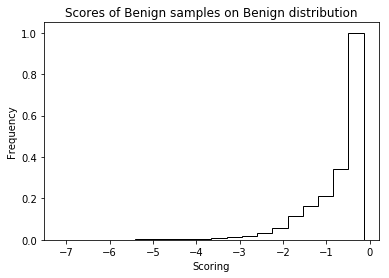

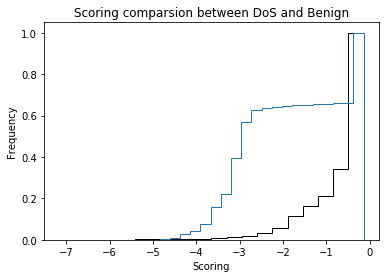

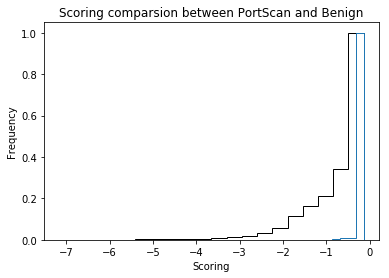

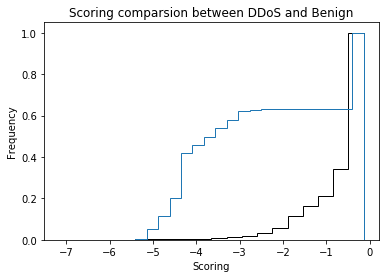

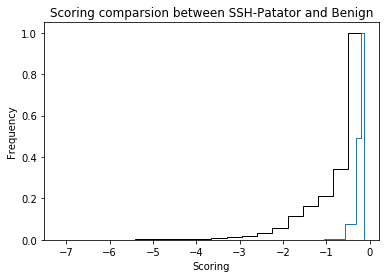

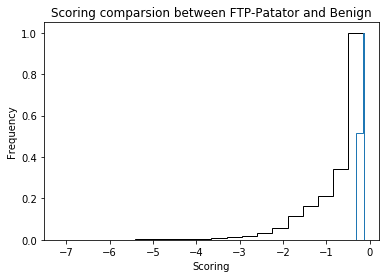

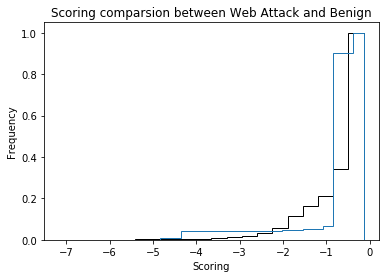

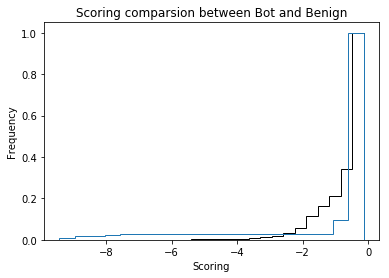

In [25]:
drawSingle('Benign')
drawComparison('Benign', 'DoS')
drawComparison('Benign', 'PortScan')
drawComparison('Benign', 'DDoS')
drawComparison('Benign', 'SSH-Patator')
drawComparison('Benign', 'FTP-Patator')
drawComparison('Benign', 'Web Attack')
drawComparison('Benign', 'Bot')
